# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

from scipy.interpolate import interp1d

from CMEP_Pseudopotential import CMEP_Atom as PseudoAtom
from CMEP import CMEP_Atom as Atom
from qsps import QSP_HNC
from constants import *
# from hnc_Ng import  HNC_solver
# from qsps import *

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
        
        
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

Ha_to_J = 4.359744e-18
k_B = 1.380649e-23 
m_p = 1.672621898e-27 # kg
eV_to_K = 11604.5250061598
J_to_erg = 1e7
Ha_to_erg = Ha_to_J*J_to_erg

# Function that sets up HNC QSP 

In [2]:
atom_name = 'He'#,"He","Li","Be"]

ni_cc = 2.013e23 # 1/m^3
Te_eV = 30
Ti_eV = Te_eV
Z, A = 2,4

# Average Atom Information

AA_Zbar = 1.39
Zbar = AA_Zbar

ri = 2 #2.526
folder = '/home/zach/plasma/atoMEC/examples/'
# AA_file = 'H_rs_2.526_T10eV.csv'
AA_file = 'He_rs_2.000_T30.0eV.csv'

##########
ni_AU = ni_cc*1e6*aB**3

r_s_AU = QSP_HNC.rs_from_n(ni_AU)
r_c = 0
if r_c>1:
    r_c=1e-5
print("Te = {0:.3e} eV, n_i = {1:.3e} 1/cc".format(Te_eV, ni_cc))
print("Te = {0:.3e} K, ρ = {1:.3e} [g/cc] ".format(Te_eV*eV_to_K, 0))#1e3*ni_cc*m_p*A ))
print("r_s = {0:.3f}, r_c/r_s = {1:.3f}".format(r_s_AU, r_c))

Te = 3.000e+01 eV, n_i = 2.013e+23 1/cc
Te = 3.481e+05 K, ρ = 0.000e+00 [g/cc] 
r_s = 2.000, r_c/r_s = 0.000


##  Read in AA Bound state Density

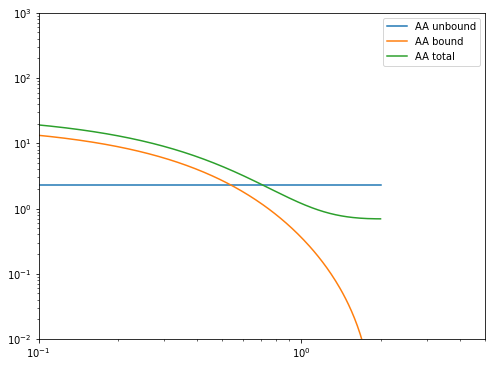

In [5]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
# axs = np.array([[axs]])

nbar_f = (Z-AA_Zbar)/( 4/3*π*ri**3 )
nbar_b = AA_Zbar/ (  4/3*π*ri**3 )
nbar_tot = Z/( 4/3*π*ri**3 )

AA_data = read_csv(folder + AA_file, delim_whitespace=True,header=0)
unbound_h = np.array( (AA_data['n[unbound]'])/nbar_f )
bound_h = np.array((AA_data['n[bound]'])/nbar_b)/2
total_h = np.array((AA_data['n[bound]'] + AA_data['n[unbound]'])/nbar_tot)
# ax.plot(r_array, gei_func(r_array,κ=15))
ax.plot(AA_data['r[a_0]'], unbound_h, label='AA unbound' )
ax.plot(AA_data['r[a_0]'], bound_h , label='AA bound')
ax.plot(AA_data['r[a_0]'], total_h, label='AA total' )

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(1e-1,5)
ax.set_ylim(1e-2,1000)
# ax.set_ylim(0.1*np.min(gei),10*np.max(gei))

ax.legend()

##### set bound state h

In [6]:
atom = Atom(Z, A, ni_cc, Ti_eV, Te_eV, Zbar=Z,
                 βu_options = {'add_bridge':True, 'pseudopotential':False}, 
                 qsp_options= {'r_c':0},
                 hnc_options= {'kappa_multiscale':10, 'R_max':5,'N_bins':500, 'h_max':1e3,
                               'oz_method':'svt'},
                 hnc_solve_options={'alpha_Picard':0.2})

atom.run_hnc()

Te_in_eV: 30.000
Ti_in_eV: 30.000
0: Initial condition Total Error: 1.595e+00
Exiting status 0, reverting to best index so far: 94
Final iter:95, Total Error: 8.776e-09


In [7]:
c_s_k_guess = atom.hnc.c_s_k_matrix

### Run the Regular and Peudopotential Atoms

In [8]:
atom_fixed = PseudoAtom(Z, A, ni_cc, Ti_eV, Te_eV, Zbar=Zbar,
                 βu_options = {'add_bridge':True, 'pseudopotential':False}, 
                 qsp_options= {'r_c':0},
                 hnc_options= {'kappa_multiscale':10, 'R_max':5,'N_bins':500, 'h_max':200,
                               'oz_method':'svt'},
                 hnc_solve_options={'alpha_Picard':0.1,'num_iterations':1e3,'verbose':True,'iters_to_check':30})

fixed_species_list = [ (0,2),(2,0) ]
fixed_h_r   = interp1d(np.array(AA_data['r[a_0]']), bound_h, 
                          bounds_error=False, fill_value=(bound_h[0], 0))(atom_fixed.hnc.r_array)

atom_fixed.hnc.fixed_h_r_matrix = np.zeros_like(atom_fixed.hnc.h_r_matrix)

for species in fixed_species_list:
    atom_fixed.hnc.fixed_h_r_matrix[species] = fixed_h_r

atom_fixed.hnc.fixed_h_species  = fixed_species_list
atom_fixed.hnc.c_s_k_matrix[:2,:2] = c_s_k_guess
atom_fixed.hnc.c_s_k_matrix[2,2] = c_s_k_guess[1,1]
atom_fixed.hnc.c_s_k_matrix[0,2] = c_s_k_guess[0,1]
atom_fixed.hnc.c_s_k_matrix[2,0] = c_s_k_guess[1,0]
atom_fixed.hnc.c_s_k_matrix[2,1] = c_s_k_guess[1,1]
atom_fixed.hnc.c_s_k_matrix[1,2] = c_s_k_guess[1,1]
atom_fixed.run_hnc(c_s_k_guess = atom_fixed.hnc.c_s_k_matrix )

Te_in_eV: 30.000
Ti_in_eV: 30.000
0: Initial condition Total Error: 7.600e-09


/home/zach/plasma/hnc/hnc_pseudopotential.py:546: RuntimeWarning: divide by zero encountered in log
  βu_s_r_matrix = γs_r_matrix - np.log(h_r_matrix + 1)


1: Change in c_r: 2.196e-02, HNC Error: 5.675e+01, Total Error: 5.546e-01
2: Change in c_r: 2.059e-02, HNC Error: 4.066e+01, Total Error: 5.202e-01
3: Change in c_r: 1.913e-02, HNC Error: 3.067e+01, Total Error: 4.894e-01
4: Change in c_r: 1.755e-02, HNC Error: 2.425e+01, Total Error: 4.617e-01
5: Change in c_r: 1.584e-02, HNC Error: 2.008e+01, Total Error: 4.370e-01
6: Change in c_r: 1.399e-02, HNC Error: 1.749e+01, Total Error: 4.156e-01
7: Change in c_r: 1.204e-02, HNC Error: 1.618e+01, Total Error: 3.991e-01
8: Change in c_r: 1.012e-02, HNC Error: 1.621e+01, Total Error: 3.907e-01
9: Change in c_r: 8.567e-03, HNC Error: 1.826e+01, Total Error: 3.972e-01
10: Change in c_r: 8.176e-03, HNC Error: 2.513e+01, Total Error: 4.327e-01
11: Change in c_r: 9.971e-03, HNC Error: 5.247e+01, Total Error: 5.315e-01
12: Change in c_r: 1.483e-02, HNC Error: 4.587e+02, Total Error: 8.119e-01
13: Change in c_r: 2.607e-02, HNC Error: 9.197e+08, Total Error: 2.220e+00
14: Change in c_r: 7.434e-02, HNC 

/home/zach/plasma/hnc/hnc_pseudopotential.py:350: RuntimeWarning: overflow encountered in exp
  h_r_matrix = -1 + np.exp(γs_r_matrix - self.βu_s_r_matrix) # 2. γ_r,u_s_r  -> h_r   (HNC)
/home/zach/plasma/hnc/hnc_pseudopotential.py:451: RuntimeWarning: overflow encountered in exp
  tot_eqn =  1 + h_r_matrix  - np.exp(-self.βu_s_r_matrix + h_r_matrix - c_s_r_matrix )
/home/zach/plasma/hnc/hnc_pseudopotential.py:541: RuntimeWarning: overflow encountered in exp
  h_r_matrix = -1 + np.exp(γs_r_matrix - self.βu_s_r_matrix) # 2. γ_r,u_s_r  -> h_r   (HNC)


20: Change in c_r: 8.364e+01, HNC Error: 3.690e+87, Total Error: inf
21: Change in c_r: 7.701e+00, HNC Error: 1.526e+87, Total Error: inf
QUIT: Total error infinite.
Exiting status 1, reverting to best index so far: 8
Final iter:21, Total Error: 3.907e-01


/home/zach/plasma/hnc/hnc_pseudopotential.py:336: RuntimeWarning: overflow encountered in exp
  tot_eqn =  1 + h_r_matrix  - np.exp(-self.βu_s_r_matrix + h_r_matrix - c_s_r_matrix )



Root Finder:  False The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations. final err: 6.702e+19


In [ ]:
# c_s_k_guess = atom_fixed.hnc.c_s_k_matrix
# c_s_k_guess_2 = atom_fixed.hnc.c_s_k_matrix

In [ ]:
# atom_fixed.hnc.h_r_matrix = atom_fixed.hnc.fixed_h_r_matrix
# atom_fixed.hnc.h_r_matrix = atom_fixed.hnc.FT_r_2_k_matrix(atom_fixed.hnc.fixed_h_r_matrix)
# atom_fixed.hnc.h_r_matrix[0,0] = 1/(1+np.exp(-5*(atom_fixed.hnc.r_array-3)))-1
# atom_fixed.hnc.h_r_matrix[1,1] = 1/(1+np.exp(-5*(atom_fixed.hnc.r_array-3)))-1
# atom_fixed.hnc.h_r_matrix[2,2] = 1/(1+np.exp(-5*(atom_fixed.hnc.r_array-3)))-1
# atom_fixed.hnc.h_r_matrix[1,0] = fixed_h_r#10*np.exp(-2*atom_fixed.hnc.r_array)
# atom_fixed.hnc.h_r_matrix[0,1] = atom_fixed.hnc.h_r_matrix[1,0].copy()
# atom_fixed.hnc.h_k_matrix = atom_fixed.hnc.FT_r_2_k_matrix(atom_fixed.hnc.h_r_matrix)

# α = 0.001
# for i in range(5):
#     atom_fixed.hnc.h_k_matrix = atom_fixed.hnc.h_k_matrix*(1-α) + α*atom_fixed.hnc.guess_h_k_matrix(atom_fixed.hnc.h_k_matrix)
#     atom_fixed.hnc.h_r_matrix = atom_fixed.hnc.FT_k_2_r_matrix(atom_fixed.hnc.h_k_matrix)

###### Plot h 

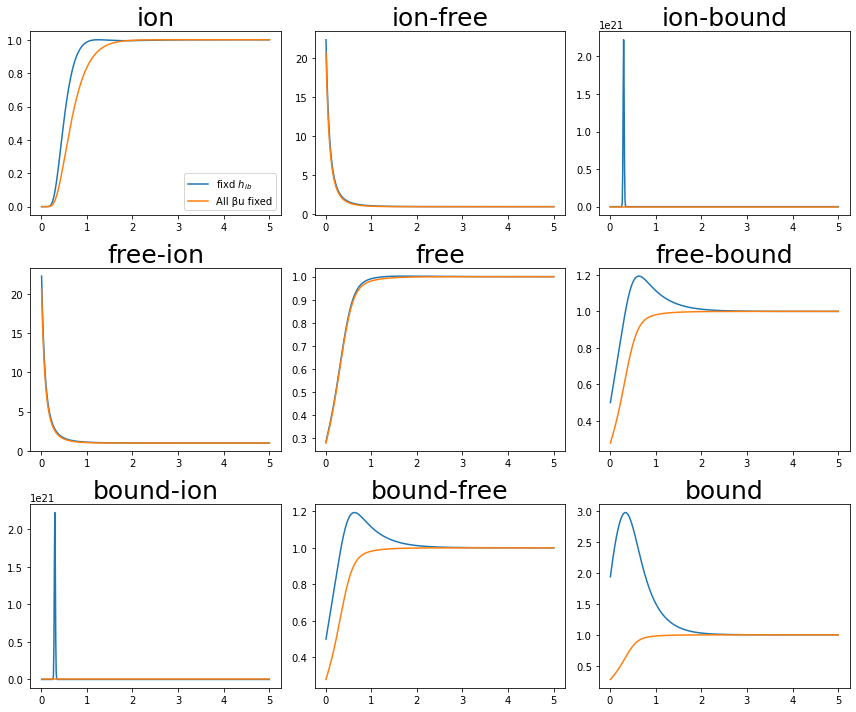

In [9]:
fig, axs = plt.subplots(3,3, figsize=(12,10))
r = atom_fixed.hnc.r_array

for i in range(3):
    for j in range(3):
        axs[i,j].set_title(atom_fixed.hnc.name_matrix[i][j],fontsize=(25))
        axs[i,j].plot(atom_fixed.hnc.r_array, atom_fixed.hnc.h_r_matrix[i,j]+1, label=r'fixd $h_{ib}$')
#         axs[i,j].plot(atom_fixed.hnc.k_array, atom_fixed.hnc.h_k_matrix[i,j]+1, label=r'fixd $h_{ib}$')
        imin, jmin = min(1,i), min(1,j)
        axs[i,j].plot(atom.hnc.r_array, atom.hnc.h_r_matrix[imin, jmin]+1, label='All βu fixed')
#         axs[i,j].set_xlim(0,20)

# ax.plot(AA_data['r[a_0]']/atom.qsp.ri,(AA_data['n[unbound]'])/AA_Zbar*4/3*π*atom.qsp.ri**3, label='AA unbound' )
# ax.plot(AA_data['r[a_0]']/atom.qsp.ri,(AA_data['n[bound]'])/(Z-AA_Zbar)*4/3*π*atom.qsp.ri**3 , label='AA bound')
# ax.plot(AA_data['r[a_0]']/atom.qsp.ri,(AA_data['n[bound]']+AA_data['n[unbound]'])/Z*4/3*π*atom.qsp.ri**3, label='AA total' )

# ax.set_yscale('log')
# ax.set_xscale('log')


# ax.set_ylim(0.1*np.min(gei),10*np.max(gei))
axs[0,0].legend()
plt.tight_layout()

###### Plot βu now that fixed h changed it

In [ ]:
fig, axs = plt.subplots(3,3, figsize=(12,10))

for i in range(3):
    for j in range(3):
        axs[i,j].plot(atom_fixed.hnc.r_array, atom_fixed.hnc.βu_s_r_matrix[i,j], label='f- QSP HNC')
#         if i<2 and j<2: 
#             axs[i,j].plot(atom.hnc.r_array, atom.hnc.βu_s_r_matrix[i,j], label='b- QSP HNC')
        


# ax.plot(AA_data['r[a_0]']/atom.qsp.ri,(AA_data['n[unbound]'])/AA_Zbar*4/3*π*atom.qsp.ri**3, label='AA unbound' )
# ax.plot(AA_data['r[a_0]']/atom.qsp.ri,(AA_data['n[bound]'])/(Z-AA_Zbar)*4/3*π*atom.qsp.ri**3 , label='AA bound')
# ax.plot(AA_data['r[a_0]']/atom.qsp.ri,(AA_data['n[bound]']+AA_data['n[unbound]'])/Z*4/3*π*atom.qsp.ri**3, label='AA total' )

# ax.set_yscale('log')
# ax.set_xscale('log')
# ax.set_xlim(1e-3,5)

# ax.set_ylim(0.1*np.min(gei),10*np.max(gei))
axs[0,0].legend()
plt.tight_layout()